# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    return separable_conv2d_batchnorm(input_layer, filters, strides)

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concatenated_layer = layers.concatenate([upsampled_layer, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    preoutput_layer = separable_conv2d_batchnorm(concatenated_layer, filters)
    output_layer = separable_conv2d_batchnorm(preoutput_layer, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    f = 32
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    encoder_layer1 = encoder_block(inputs, f, 2)
    encoder_layer2 = encoder_block(encoder_layer1, 2*f, 2)
    encoder_layer3 = encoder_block(encoder_layer2, 4*f, 2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    mid_layer = conv2d_batchnorm(encoder_layer3, 4*f ,kernel_size=1,strides=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decoder_layer1 = decoder_block(mid_layer, encoder_layer2, 4*f)
    decoder_layer2 = decoder_block(decoder_layer1, encoder_layer1, 2*f)
    decoder_layer3 = decoder_block(decoder_layer2, inputs, f)
    
    # The function returns the output layer of your model
    outputs = layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(decoder_layer3)
    
    # Print network shapes
    print(inputs)
    print(encoder_layer1)
    print(encoder_layer2)
    print(encoder_layer3)
    print(mid_layer)
    print(decoder_layer1)
    print(decoder_layer2)
    print(decoder_layer3)
    print(outputs)
    
    return outputs

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

Tensor("input_1:0", shape=(?, 160, 160, 3), dtype=float32)
Tensor("batch_normalization/batchnorm/add_1:0", shape=(?, 80, 80, 32), dtype=float32)
Tensor("batch_normalization_2/batchnorm/add_1:0", shape=(?, 40, 40, 64), dtype=float32)
Tensor("batch_normalization_3/batchnorm/add_1:0", shape=(?, 20, 20, 128), dtype=float32)
Tensor("batch_normalization_4/batchnorm/add_1:0", shape=(?, 20, 20, 128), dtype=float32)
Tensor("batch_normalization_6/batchnorm/add_1:0", shape=(?, 40, 40, 128), dtype=float32)
Tensor("batch_normalization_8/batchnorm/add_1:0", shape=(?, 80, 80, 64), dtype=float32)
Tensor("batch_normalization_10/batchnorm/add_1:0", shape=(?, 160, 160, 32), dtype=float32)
Tensor("conv2d_2/truediv:0", shape=(?, 160, 160, 3), dtype=float32)


### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
number_of_validation_images = 1184
number_of_training_images = 4131 

learning_rate = 0.002
num_epochs = 100
batch_size = 40
steps_per_epoch = number_of_training_images // batch_size + 1
validation_steps = number_of_validation_images // batch_size + 1
workers = 10

print("steps per epoch: ", steps_per_epoch)
print("validation steps: ", validation_steps)

steps per epoch:  104
validation steps:  30


Epoch 1/100
103/104 [============================>.] - ETA: 0s - loss: 0.5242

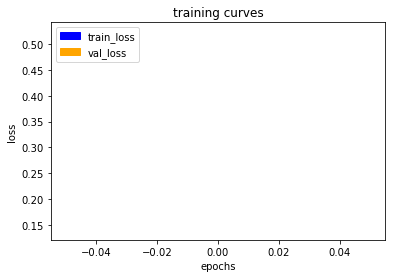

104/104 [==============================] - 79s - loss: 0.5204 - val_loss: 0.1404
Epoch 2/100
103/104 [============================>.] - ETA: 0s - loss: 0.0850

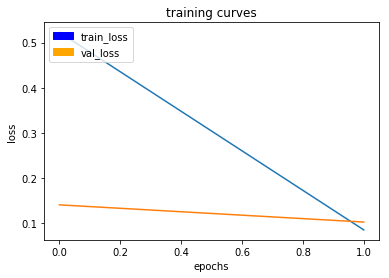

104/104 [==============================] - 75s - loss: 0.0847 - val_loss: 0.1023
Epoch 3/100
103/104 [============================>.] - ETA: 0s - loss: 0.0531

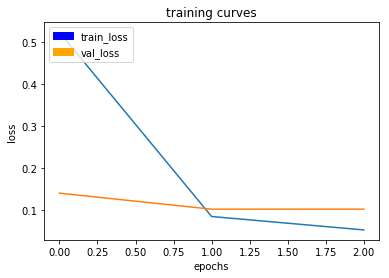

104/104 [==============================] - 75s - loss: 0.0529 - val_loss: 0.1024
Epoch 4/100
103/104 [============================>.] - ETA: 0s - loss: 0.0417

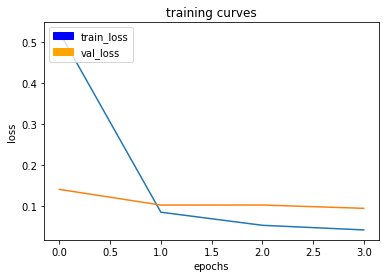

104/104 [==============================] - 76s - loss: 0.0419 - val_loss: 0.0943
Epoch 5/100
103/104 [============================>.] - ETA: 0s - loss: 0.0359

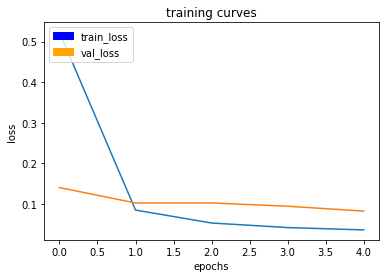

104/104 [==============================] - 75s - loss: 0.0359 - val_loss: 0.0823
Epoch 6/100
103/104 [============================>.] - ETA: 0s - loss: 0.0329

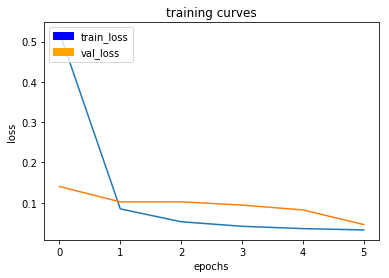

104/104 [==============================] - 76s - loss: 0.0328 - val_loss: 0.0462
Epoch 7/100
103/104 [============================>.] - ETA: 0s - loss: 0.0306

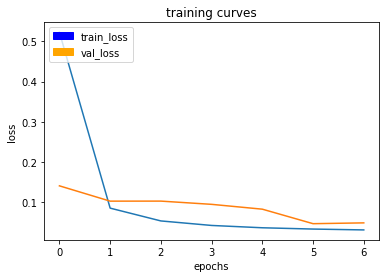

104/104 [==============================] - 75s - loss: 0.0306 - val_loss: 0.0482
Epoch 8/100
103/104 [============================>.] - ETA: 0s - loss: 0.0289

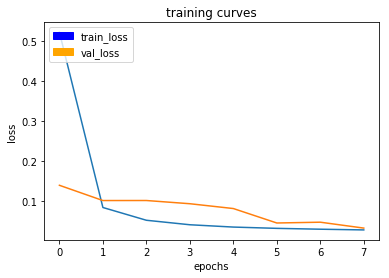

104/104 [==============================] - 75s - loss: 0.0288 - val_loss: 0.0334
Epoch 9/100
103/104 [============================>.] - ETA: 0s - loss: 0.0271

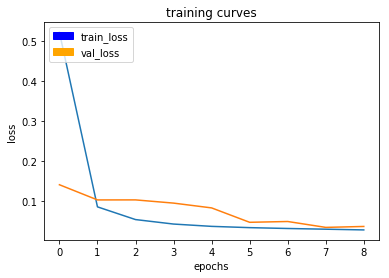

104/104 [==============================] - 75s - loss: 0.0271 - val_loss: 0.0357
Epoch 10/100
103/104 [============================>.] - ETA: 0s - loss: 0.0259

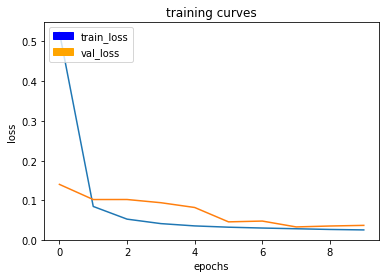

104/104 [==============================] - 75s - loss: 0.0259 - val_loss: 0.0373
Epoch 11/100
103/104 [============================>.] - ETA: 0s - loss: 0.0254

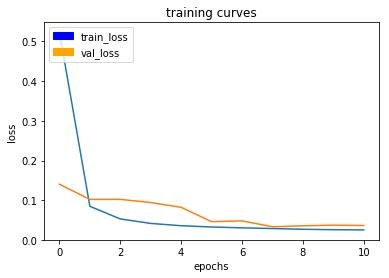

104/104 [==============================] - 76s - loss: 0.0253 - val_loss: 0.0365
Epoch 12/100
103/104 [============================>.] - ETA: 0s - loss: 0.0241

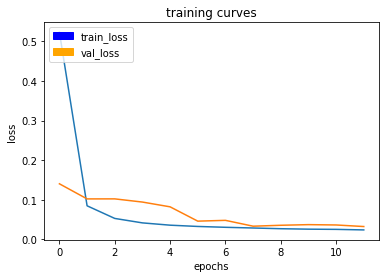

104/104 [==============================] - 75s - loss: 0.0241 - val_loss: 0.0325
Epoch 13/100
103/104 [============================>.] - ETA: 0s - loss: 0.0229

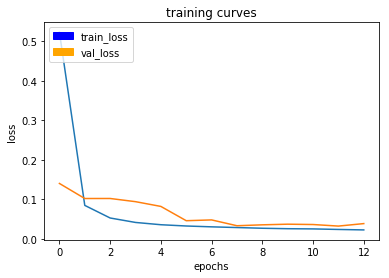

104/104 [==============================] - 77s - loss: 0.0229 - val_loss: 0.0388
Epoch 14/100
103/104 [============================>.] - ETA: 0s - loss: 0.0220

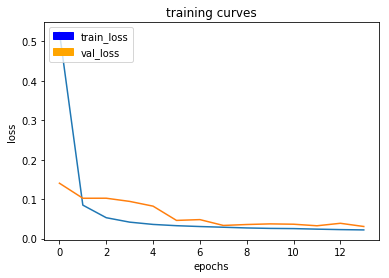

104/104 [==============================] - 76s - loss: 0.0220 - val_loss: 0.0307
Epoch 15/100
103/104 [============================>.] - ETA: 0s - loss: 0.0232

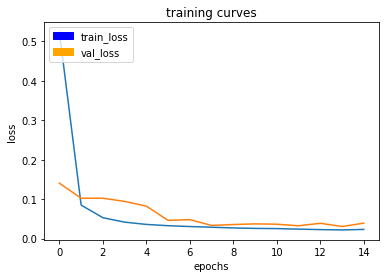

104/104 [==============================] - 77s - loss: 0.0233 - val_loss: 0.0392
Epoch 16/100
103/104 [============================>.] - ETA: 0s - loss: 0.0222

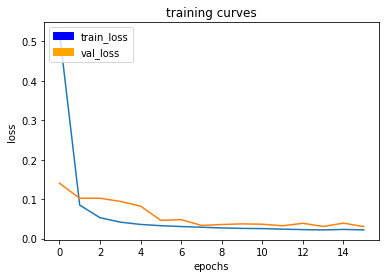

104/104 [==============================] - 75s - loss: 0.0222 - val_loss: 0.0305
Epoch 17/100
103/104 [============================>.] - ETA: 0s - loss: 0.0229

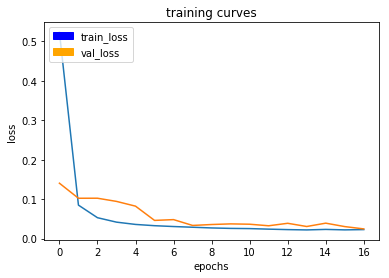

104/104 [==============================] - 75s - loss: 0.0228 - val_loss: 0.0246
Epoch 18/100
103/104 [============================>.] - ETA: 0s - loss: 0.0200

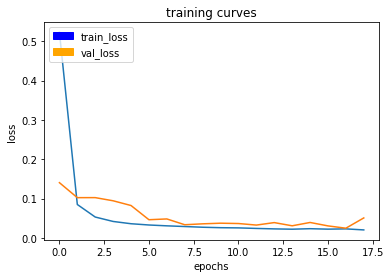

104/104 [==============================] - 76s - loss: 0.0202 - val_loss: 0.0507
Epoch 19/100
103/104 [============================>.] - ETA: 0s - loss: 0.0196

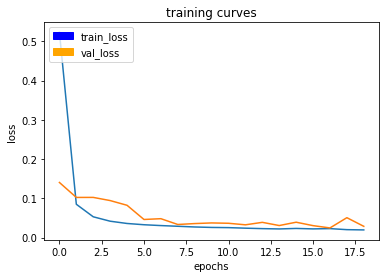

104/104 [==============================] - 76s - loss: 0.0196 - val_loss: 0.0287
Epoch 20/100
103/104 [============================>.] - ETA: 0s - loss: 0.0186

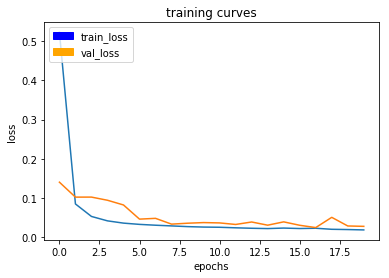

104/104 [==============================] - 76s - loss: 0.0186 - val_loss: 0.0277
Epoch 21/100
103/104 [============================>.] - ETA: 0s - loss: 0.0186

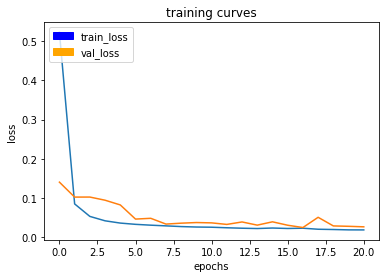

104/104 [==============================] - 76s - loss: 0.0185 - val_loss: 0.0264
Epoch 22/100
103/104 [============================>.] - ETA: 0s - loss: 0.0181

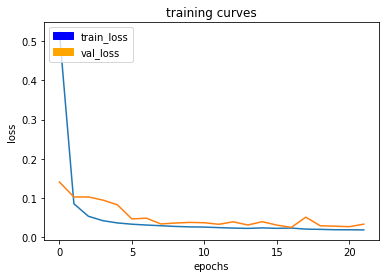

104/104 [==============================] - 76s - loss: 0.0182 - val_loss: 0.0329
Epoch 23/100
103/104 [============================>.] - ETA: 0s - loss: 0.0183

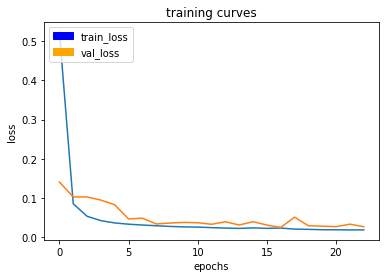

104/104 [==============================] - 76s - loss: 0.0183 - val_loss: 0.0263
Epoch 24/100
103/104 [============================>.] - ETA: 0s - loss: 0.0176

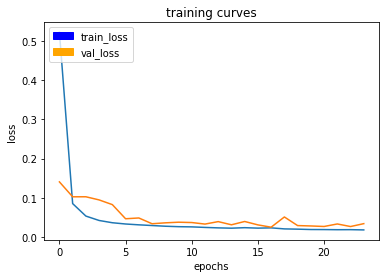

104/104 [==============================] - 76s - loss: 0.0176 - val_loss: 0.0337
Epoch 25/100
103/104 [============================>.] - ETA: 0s - loss: 0.0176- ETA: 4s - loss: 

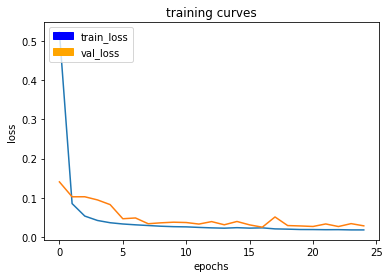

104/104 [==============================] - 76s - loss: 0.0176 - val_loss: 0.0280
Epoch 26/100
103/104 [============================>.] - ETA: 0s - loss: 0.0168

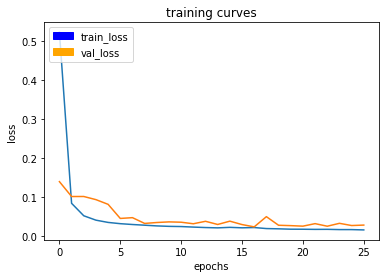

104/104 [==============================] - 76s - loss: 0.0168 - val_loss: 0.0291
Epoch 27/100
103/104 [============================>.] - ETA: 0s - loss: 0.0177

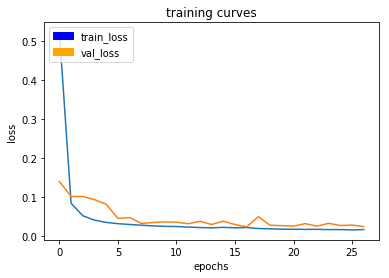

104/104 [==============================] - 76s - loss: 0.0177 - val_loss: 0.0255
Epoch 28/100
103/104 [============================>.] - ETA: 0s - loss: 0.0174

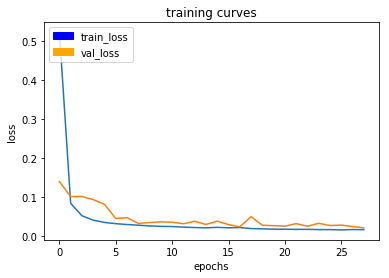

104/104 [==============================] - 76s - loss: 0.0174 - val_loss: 0.0221
Epoch 29/100
103/104 [============================>.] - ETA: 0s - loss: 0.0180

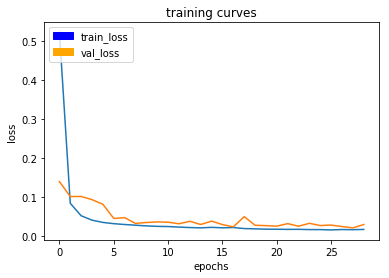

104/104 [==============================] - 76s - loss: 0.0180 - val_loss: 0.0306
Epoch 30/100
103/104 [============================>.] - ETA: 0s - loss: 0.0174

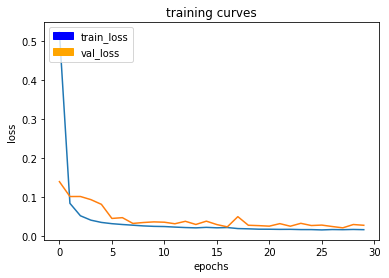

104/104 [==============================] - 76s - loss: 0.0174 - val_loss: 0.0287
Epoch 31/100
103/104 [============================>.] - ETA: 0s - loss: 0.0154

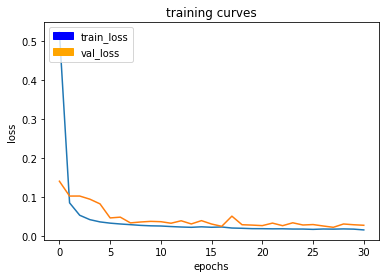

104/104 [==============================] - 76s - loss: 0.0154 - val_loss: 0.0273
Epoch 32/100
103/104 [============================>.] - ETA: 0s - loss: 0.0190

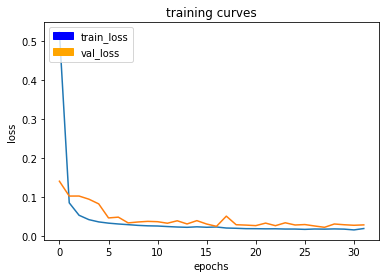

104/104 [==============================] - 76s - loss: 0.0190 - val_loss: 0.0283
Epoch 33/100
103/104 [============================>.] - ETA: 0s - loss: 0.0154- ETA: 4s - loss: 

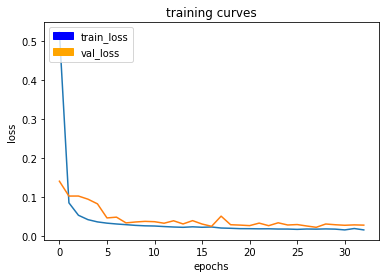

104/104 [==============================] - 76s - loss: 0.0154 - val_loss: 0.0277
Epoch 34/100
103/104 [============================>.] - ETA: 0s - loss: 0.0151

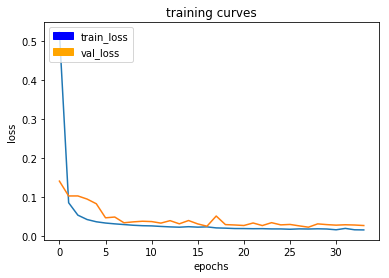

104/104 [==============================] - 76s - loss: 0.0151 - val_loss: 0.0263
Epoch 35/100
103/104 [============================>.] - ETA: 0s - loss: 0.0142

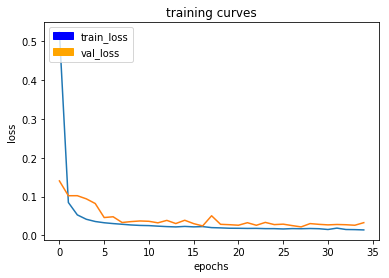

104/104 [==============================] - 76s - loss: 0.0143 - val_loss: 0.0330
Epoch 36/100
103/104 [============================>.] - ETA: 0s - loss: 0.0162

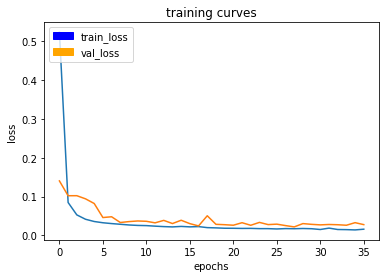

104/104 [==============================] - 76s - loss: 0.0162 - val_loss: 0.0279
Epoch 37/100
103/104 [============================>.] - ETA: 0s - loss: 0.0145

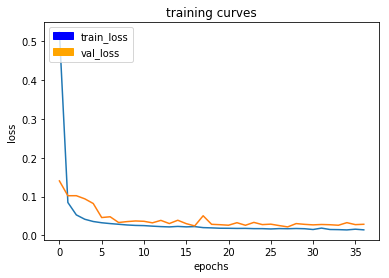

104/104 [==============================] - 75s - loss: 0.0145 - val_loss: 0.0288
Epoch 38/100
103/104 [============================>.] - ETA: 0s - loss: 0.0151

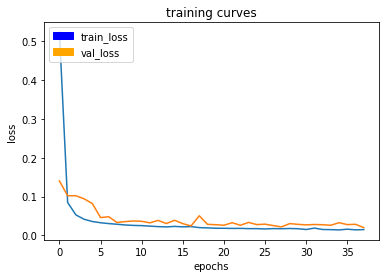

104/104 [==============================] - 77s - loss: 0.0151 - val_loss: 0.0202
Epoch 39/100
103/104 [============================>.] - ETA: 0s - loss: 0.0162

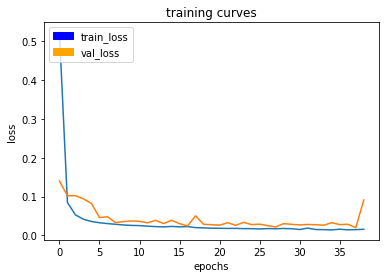

104/104 [==============================] - 76s - loss: 0.0162 - val_loss: 0.0914
Epoch 40/100
103/104 [============================>.] - ETA: 0s - loss: 0.0178

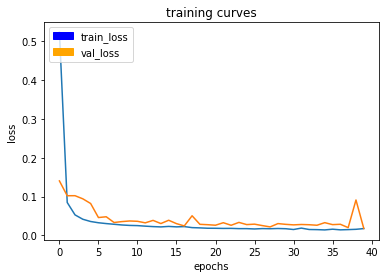

104/104 [==============================] - 76s - loss: 0.0177 - val_loss: 0.0181
Epoch 41/100
103/104 [============================>.] - ETA: 0s - loss: 0.0146

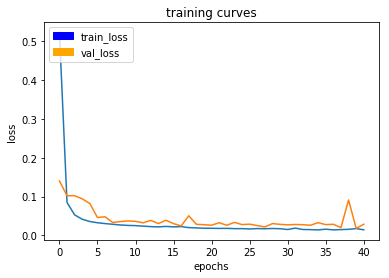

104/104 [==============================] - 75s - loss: 0.0146 - val_loss: 0.0290
Epoch 42/100
103/104 [============================>.] - ETA: 0s - loss: 0.0141

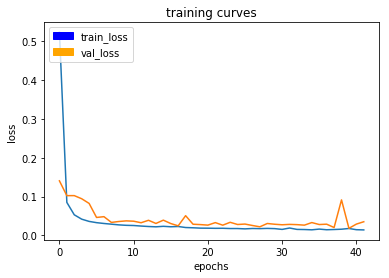

104/104 [==============================] - 77s - loss: 0.0141 - val_loss: 0.0351
Epoch 43/100
103/104 [============================>.] - ETA: 0s - loss: 0.0144

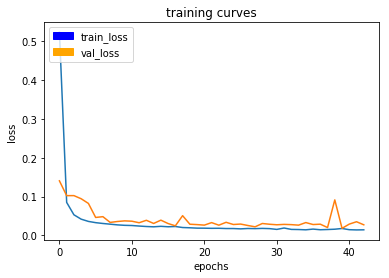

104/104 [==============================] - 76s - loss: 0.0144 - val_loss: 0.0272
Epoch 44/100
103/104 [============================>.] - ETA: 0s - loss: 0.0139

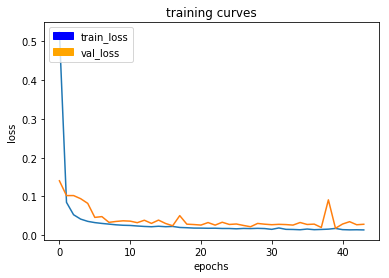

104/104 [==============================] - 76s - loss: 0.0139 - val_loss: 0.0285
Epoch 45/100
103/104 [============================>.] - ETA: 0s - loss: 0.0135

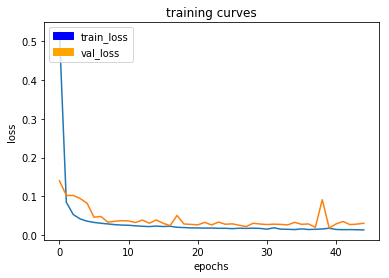

104/104 [==============================] - 76s - loss: 0.0135 - val_loss: 0.0306
Epoch 46/100
103/104 [============================>.] - ETA: 0s - loss: 0.0126

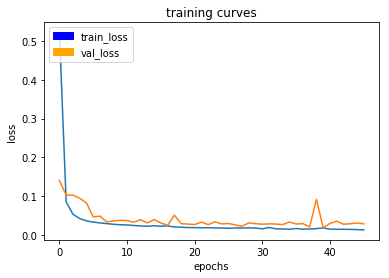

104/104 [==============================] - 76s - loss: 0.0126 - val_loss: 0.0283
Epoch 47/100
103/104 [============================>.] - ETA: 0s - loss: 0.0127

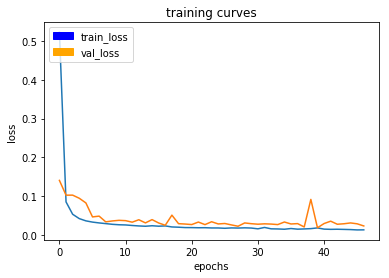

104/104 [==============================] - 75s - loss: 0.0127 - val_loss: 0.0228
Epoch 48/100
103/104 [============================>.] - ETA: 0s - loss: 0.0125

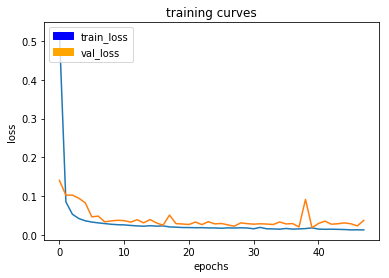

104/104 [==============================] - 76s - loss: 0.0125 - val_loss: 0.0371
Epoch 49/100
103/104 [============================>.] - ETA: 0s - loss: 0.0129

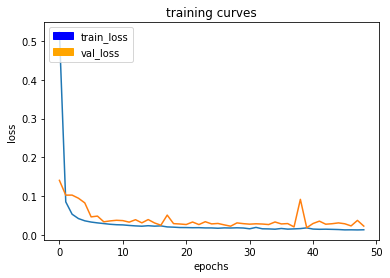

104/104 [==============================] - 76s - loss: 0.0128 - val_loss: 0.0223
Epoch 50/100
103/104 [============================>.] - ETA: 0s - loss: 0.0132

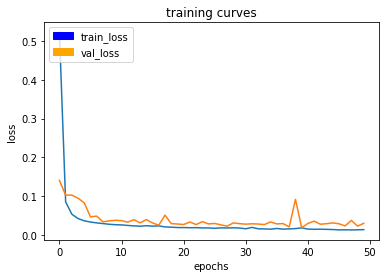

104/104 [==============================] - 76s - loss: 0.0132 - val_loss: 0.0295
Epoch 51/100
103/104 [============================>.] - ETA: 0s - loss: 0.0146

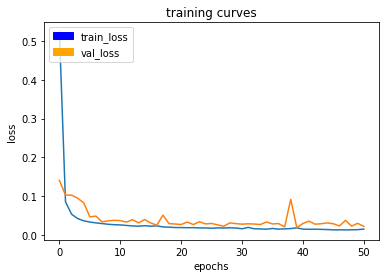

104/104 [==============================] - 76s - loss: 0.0146 - val_loss: 0.0216
Epoch 52/100
103/104 [============================>.] - ETA: 0s - loss: 0.0158

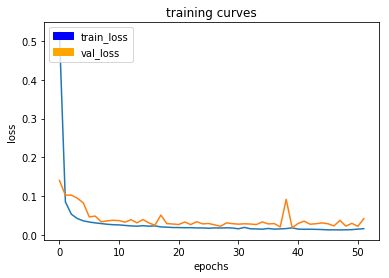

104/104 [==============================] - 76s - loss: 0.0158 - val_loss: 0.0415
Epoch 53/100
103/104 [============================>.] - ETA: 0s - loss: 0.0148

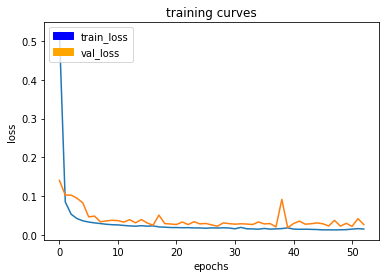

104/104 [==============================] - 75s - loss: 0.0148 - val_loss: 0.0263
Epoch 54/100
103/104 [============================>.] - ETA: 0s - loss: 0.0133

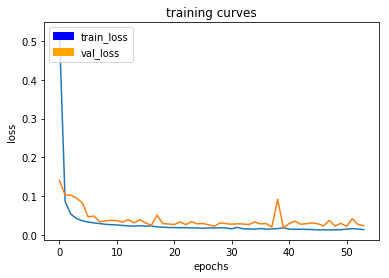

104/104 [==============================] - 77s - loss: 0.0133 - val_loss: 0.0235
Epoch 55/100
103/104 [============================>.] - ETA: 0s - loss: 0.0129

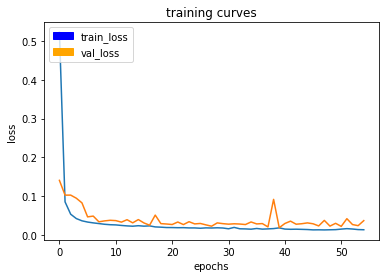

104/104 [==============================] - 76s - loss: 0.0129 - val_loss: 0.0365
Epoch 56/100
103/104 [============================>.] - ETA: 0s - loss: 0.0136

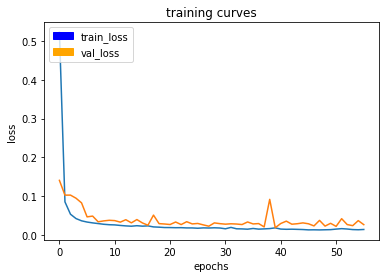

104/104 [==============================] - 76s - loss: 0.0136 - val_loss: 0.0261
Epoch 57/100
103/104 [============================>.] - ETA: 0s - loss: 0.0125

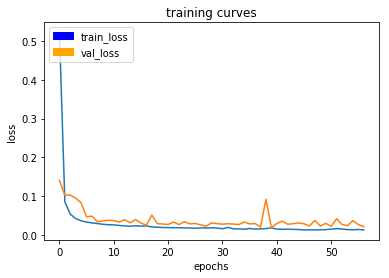

104/104 [==============================] - 76s - loss: 0.0125 - val_loss: 0.0208
Epoch 58/100
103/104 [============================>.] - ETA: 0s - loss: 0.0118

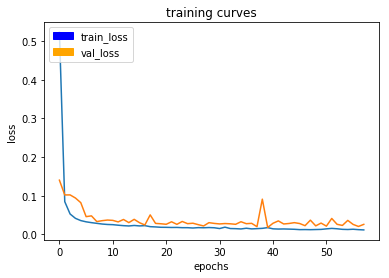

104/104 [==============================] - 76s - loss: 0.0118 - val_loss: 0.0262
Epoch 59/100
103/104 [============================>.] - ETA: 0s - loss: 0.0116

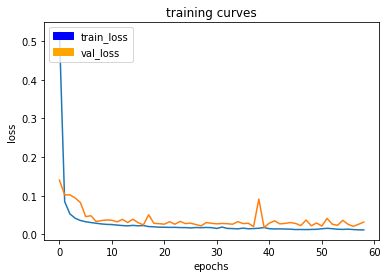

104/104 [==============================] - 75s - loss: 0.0116 - val_loss: 0.0319
Epoch 60/100
103/104 [============================>.] - ETA: 0s - loss: 0.0112

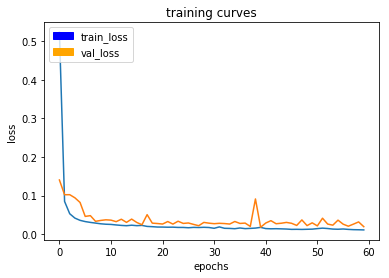

104/104 [==============================] - 77s - loss: 0.0112 - val_loss: 0.0196
Epoch 61/100
103/104 [============================>.] - ETA: 0s - loss: 0.0117

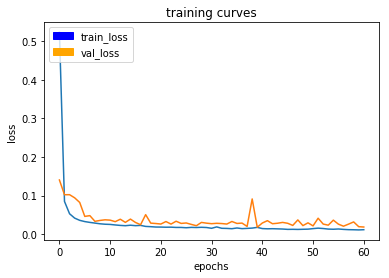

104/104 [==============================] - 75s - loss: 0.0117 - val_loss: 0.0187
Epoch 62/100
103/104 [============================>.] - ETA: 0s - loss: 0.0118

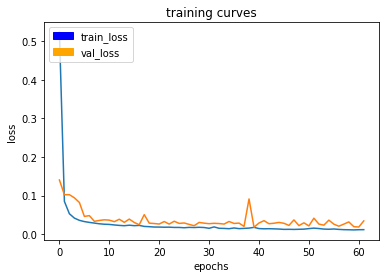

104/104 [==============================] - 77s - loss: 0.0118 - val_loss: 0.0345
Epoch 63/100
103/104 [============================>.] - ETA: 0s - loss: 0.0128

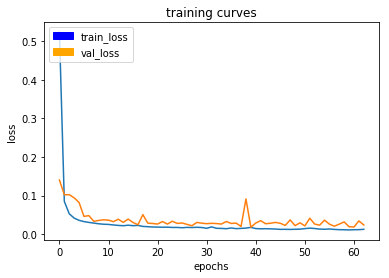

104/104 [==============================] - 76s - loss: 0.0127 - val_loss: 0.0239
Epoch 64/100
103/104 [============================>.] - ETA: 0s - loss: 0.0114

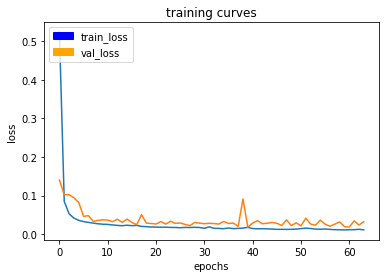

104/104 [==============================] - 76s - loss: 0.0114 - val_loss: 0.0324
Epoch 65/100
103/104 [============================>.] - ETA: 0s - loss: 0.0110

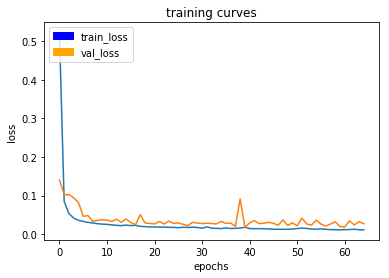

104/104 [==============================] - 76s - loss: 0.0110 - val_loss: 0.0269
Epoch 66/100
103/104 [============================>.] - ETA: 0s - loss: 0.0114

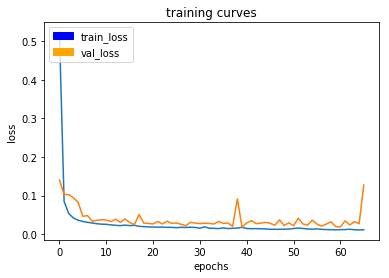

104/104 [==============================] - 76s - loss: 0.0114 - val_loss: 0.1273
Epoch 67/100
103/104 [============================>.] - ETA: 0s - loss: 0.0169

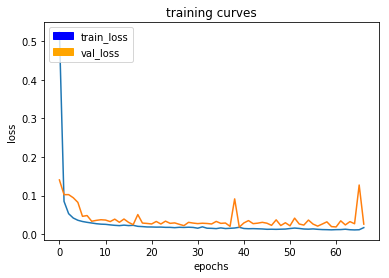

104/104 [==============================] - 75s - loss: 0.0169 - val_loss: 0.0260
Epoch 68/100
103/104 [============================>.] - ETA: 0s - loss: 0.0124

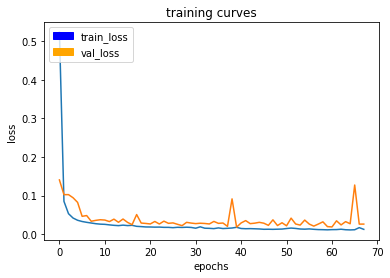

104/104 [==============================] - 76s - loss: 0.0124 - val_loss: 0.0261
Epoch 69/100
103/104 [============================>.] - ETA: 0s - loss: 0.0120

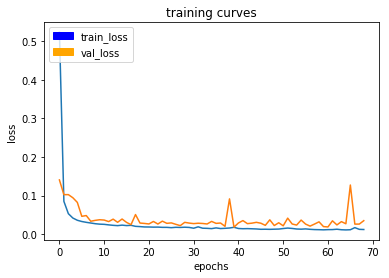

104/104 [==============================] - 76s - loss: 0.0120 - val_loss: 0.0349
Epoch 70/100
103/104 [============================>.] - ETA: 0s - loss: 0.0141

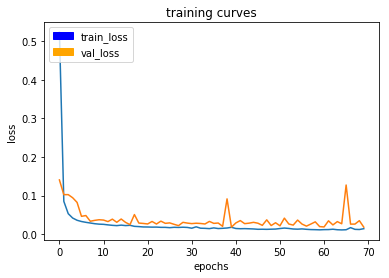

104/104 [==============================] - 75s - loss: 0.0141 - val_loss: 0.0181
Epoch 71/100
103/104 [============================>.] - ETA: 0s - loss: 0.0121

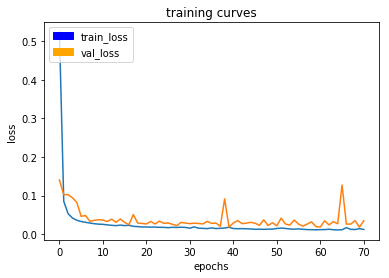

104/104 [==============================] - 75s - loss: 0.0121 - val_loss: 0.0347
Epoch 72/100
103/104 [============================>.] - ETA: 0s - loss: 0.0110- ETA: 4s - loss: 

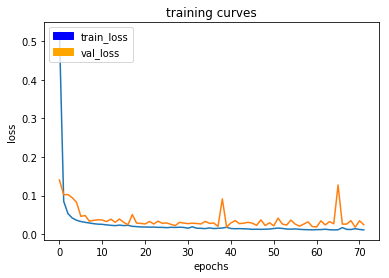

104/104 [==============================] - 76s - loss: 0.0110 - val_loss: 0.0245
Epoch 73/100
103/104 [============================>.] - ETA: 0s - loss: 0.0121

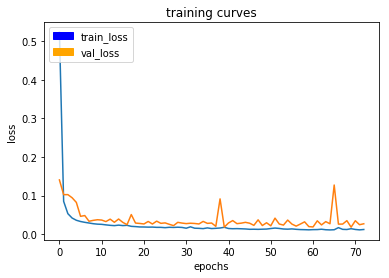

104/104 [==============================] - 76s - loss: 0.0120 - val_loss: 0.0269
Epoch 74/100
103/104 [============================>.] - ETA: 0s - loss: 0.0112

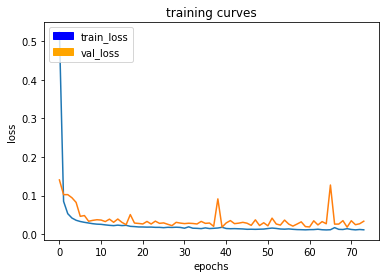

104/104 [==============================] - 75s - loss: 0.0113 - val_loss: 0.0335
Epoch 75/100
103/104 [============================>.] - ETA: 0s - loss: 0.0122

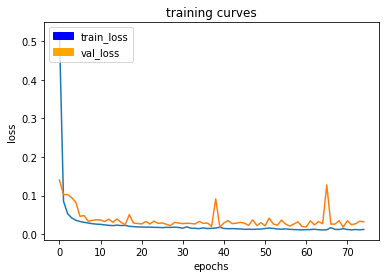

104/104 [==============================] - 76s - loss: 0.0122 - val_loss: 0.0320
Epoch 76/100
103/104 [============================>.] - ETA: 0s - loss: 0.0110

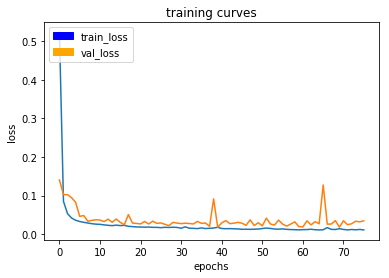

104/104 [==============================] - 76s - loss: 0.0110 - val_loss: 0.0345
Epoch 77/100
103/104 [============================>.] - ETA: 0s - loss: 0.0107

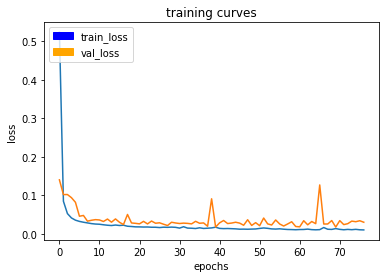

104/104 [==============================] - 76s - loss: 0.0107 - val_loss: 0.0306
Epoch 78/100
103/104 [============================>.] - ETA: 0s - loss: 0.0105

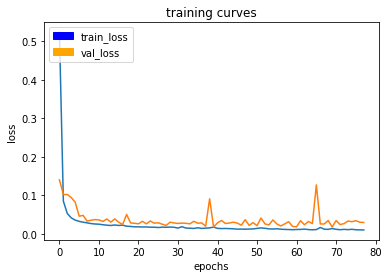

104/104 [==============================] - 76s - loss: 0.0106 - val_loss: 0.0299
Epoch 79/100
103/104 [============================>.] - ETA: 0s - loss: 0.0109

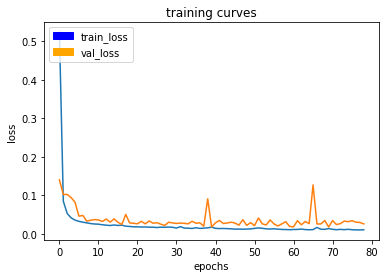

104/104 [==============================] - 76s - loss: 0.0109 - val_loss: 0.0262
Epoch 80/100
103/104 [============================>.] - ETA: 0s - loss: 0.0105

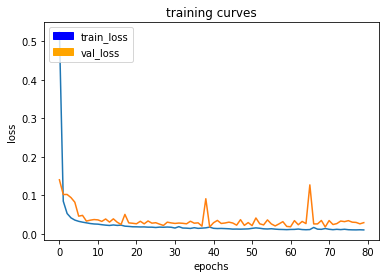

104/104 [==============================] - 76s - loss: 0.0105 - val_loss: 0.0293
Epoch 81/100
103/104 [============================>.] - ETA: 0s - loss: 0.0105

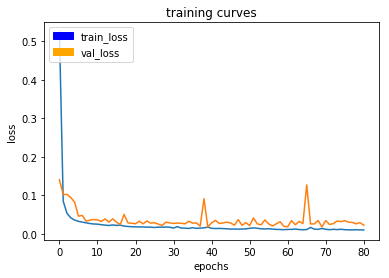

104/104 [==============================] - 76s - loss: 0.0104 - val_loss: 0.0226
Epoch 82/100
103/104 [============================>.] - ETA: 0s - loss: 0.0102

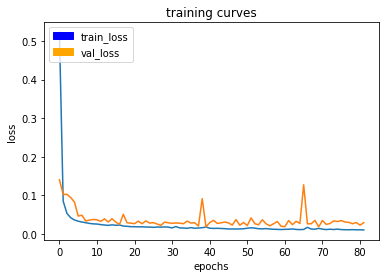

104/104 [==============================] - 76s - loss: 0.0102 - val_loss: 0.0290
Epoch 83/100
103/104 [============================>.] - ETA: 0s - loss: 0.0100

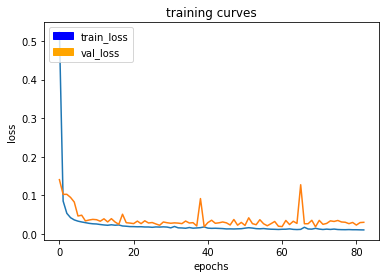

104/104 [==============================] - 76s - loss: 0.0100 - val_loss: 0.0297
Epoch 84/100
103/104 [============================>.] - ETA: 0s - loss: 0.0100

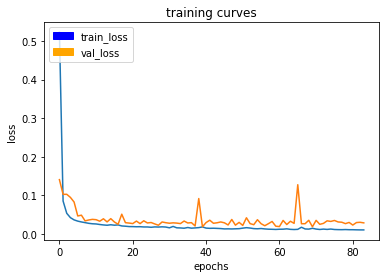

104/104 [==============================] - 76s - loss: 0.0100 - val_loss: 0.0282
Epoch 85/100
103/104 [============================>.] - ETA: 0s - loss: 0.0100

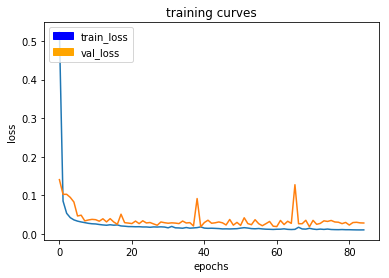

104/104 [==============================] - 76s - loss: 0.0100 - val_loss: 0.0279
Epoch 86/100
103/104 [============================>.] - ETA: 0s - loss: 0.0100

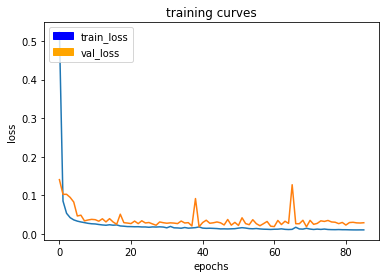

104/104 [==============================] - 75s - loss: 0.0100 - val_loss: 0.0286
Epoch 87/100
103/104 [============================>.] - ETA: 0s - loss: 0.0103

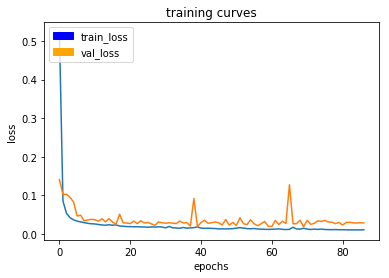

104/104 [==============================] - 76s - loss: 0.0103 - val_loss: 0.0281
Epoch 88/100
103/104 [============================>.] - ETA: 0s - loss: 0.0098

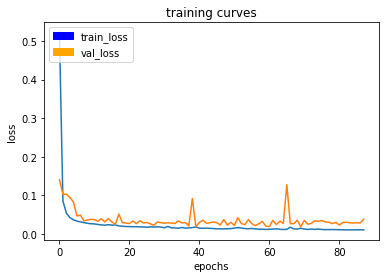

104/104 [==============================] - 76s - loss: 0.0098 - val_loss: 0.0378
Epoch 89/100
103/104 [============================>.] - ETA: 0s - loss: 0.0111

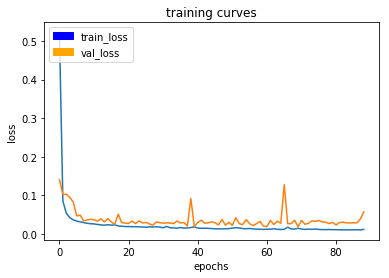

104/104 [==============================] - 75s - loss: 0.0111 - val_loss: 0.0565
Epoch 90/100
103/104 [============================>.] - ETA: 0s - loss: 0.0155

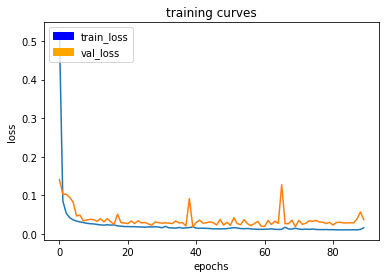

104/104 [==============================] - 77s - loss: 0.0154 - val_loss: 0.0362
Epoch 91/100
103/104 [============================>.] - ETA: 0s - loss: 0.0125- ETA: 4s - loss: 

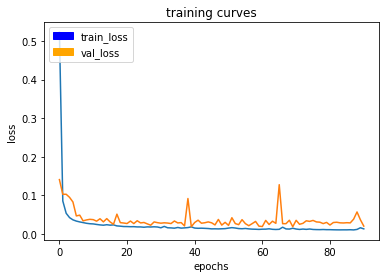

104/104 [==============================] - 76s - loss: 0.0125 - val_loss: 0.0197
Epoch 92/100
103/104 [============================>.] - ETA: 0s - loss: 0.0113

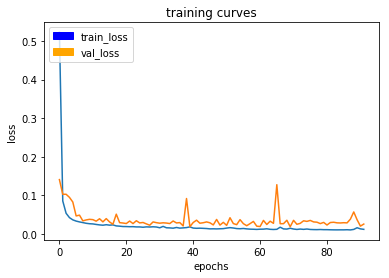

104/104 [==============================] - 77s - loss: 0.0113 - val_loss: 0.0250
Epoch 93/100
103/104 [============================>.] - ETA: 0s - loss: 0.0102

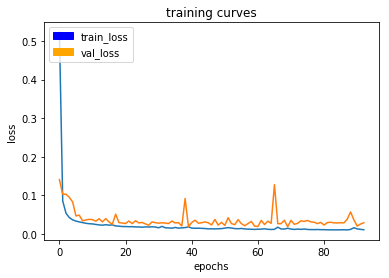

104/104 [==============================] - 75s - loss: 0.0102 - val_loss: 0.0284
Epoch 94/100
103/104 [============================>.] - ETA: 0s - loss: 0.0101

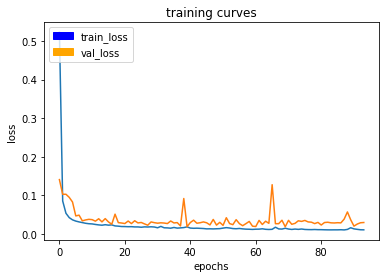

104/104 [==============================] - 76s - loss: 0.0101 - val_loss: 0.0291
Epoch 95/100
103/104 [============================>.] - ETA: 0s - loss: 0.0102

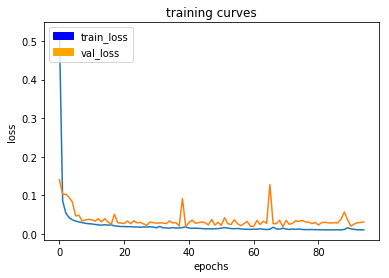

104/104 [==============================] - 76s - loss: 0.0102 - val_loss: 0.0306
Epoch 96/100
103/104 [============================>.] - ETA: 0s - loss: 0.0102

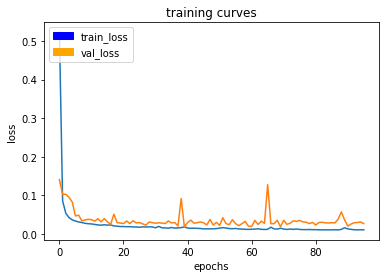

104/104 [==============================] - 76s - loss: 0.0102 - val_loss: 0.0262
Epoch 97/100
103/104 [============================>.] - ETA: 0s - loss: 0.0104

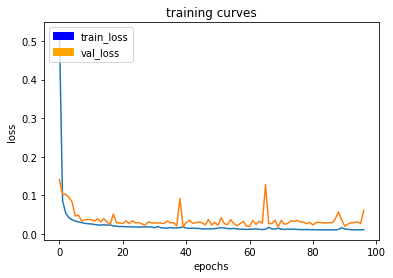

104/104 [==============================] - 75s - loss: 0.0104 - val_loss: 0.0607
Epoch 98/100
103/104 [============================>.] - ETA: 0s - loss: 0.0179

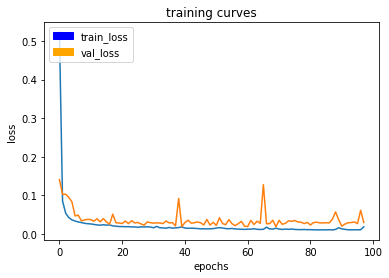

104/104 [==============================] - 76s - loss: 0.0178 - val_loss: 0.0291
Epoch 99/100
103/104 [============================>.] - ETA: 0s - loss: 0.0115

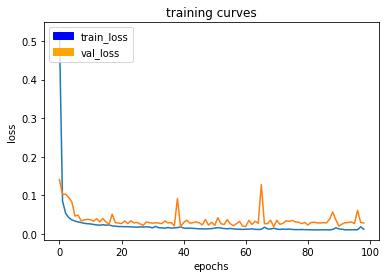

104/104 [==============================] - 76s - loss: 0.0115 - val_loss: 0.0278
Epoch 100/100
103/104 [============================>.] - ETA: 0s - loss: 0.0115

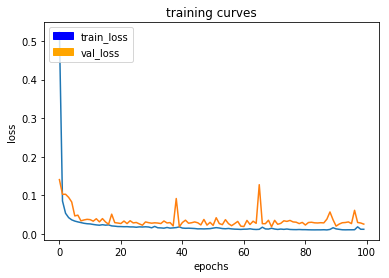

104/104 [==============================] - 76s - loss: 0.0115 - val_loss: 0.0249


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

#model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')
model.compile(optimizer=keras.optimizers.Nadam(lr=learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.
from utils import model_tools
weight_file_name = 'model_weights'
restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [12]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

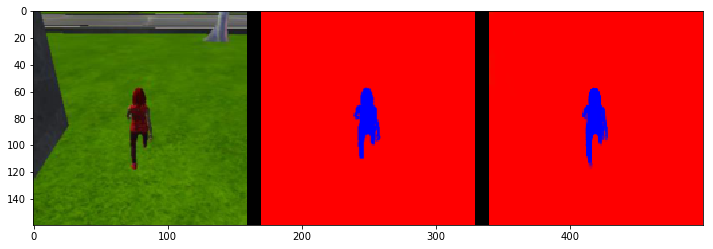

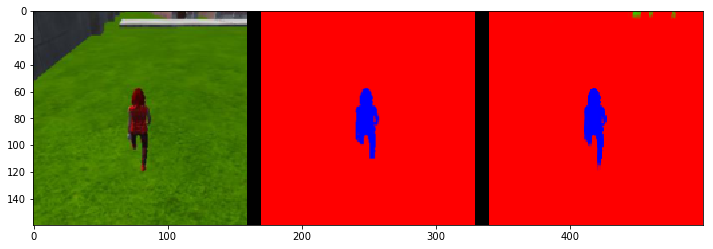

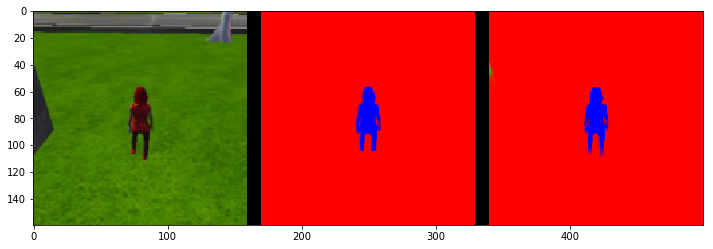

In [13]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

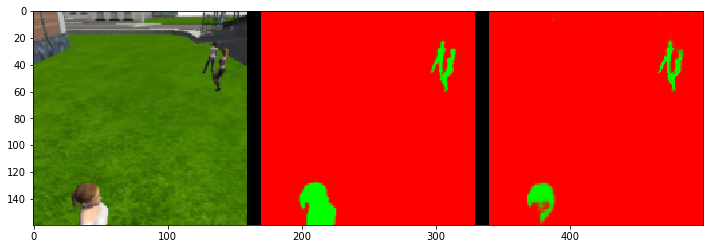

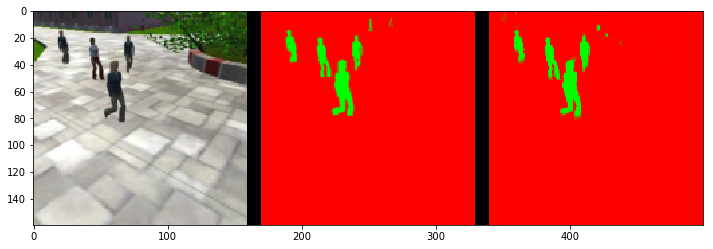

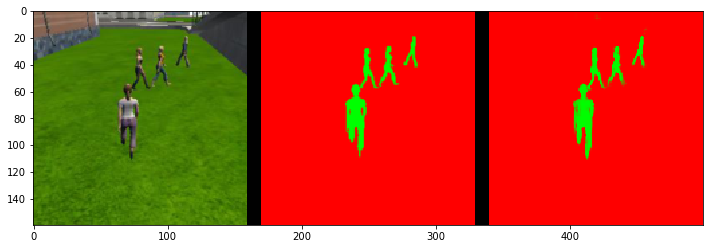

In [14]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

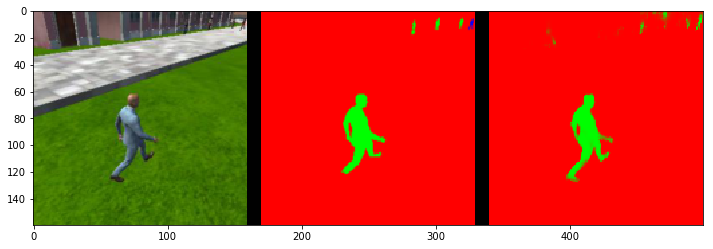

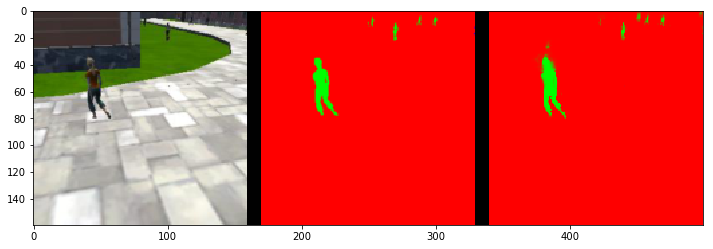

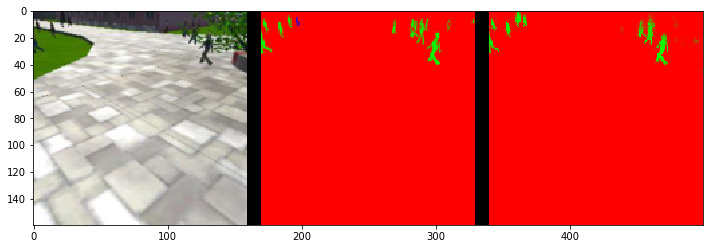

In [15]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [16]:
os.chdir("/home/ubuntu/RoboND-DeepLearning-Project/code/")

# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9961397558645484
average intersection over union for other people is 0.3743532487023496
average intersection over union for the hero is 0.9029787627562927
number true positives: 539, number false positives: 0, number false negatives: 0


In [17]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9887269368495564
average intersection over union for other people is 0.7747909871505095
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 26, number false negatives: 0


In [18]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9966108487980894
average intersection over union for other people is 0.45975077711685136
average intersection over union for the hero is 0.1865456882420774
number true positives: 112, number false positives: 1, number false negatives: 189


In [19]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7508650519031141


In [20]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.544762225499


In [21]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.409042916724


In [22]:
img_dir = "/home/ubuntu/RoboND-DeepLearning-Project/data/train/masks"
total_files, total_hero = 0, 0
os.chdir(img_dir)
for file in glob.glob("*.png"):
  total_files +=1
  img = misc.imread(file, flatten=False, mode='RGB')
  blue = img[:,:,2]

  if np.any(blue == 255):
    total_hero += 1

percent_hero = 100. * total_hero / total_files

print (percent_hero, "percent of files contain the hero")

37.64221738077947 percent of files contain the hero
